In [1]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
sys.path.append('../lib/')
import ImportNotebook
%matplotlib inline
import numpy as np
import numpy.matrixlib
import cv2
import time
import asmgazetracker
import matplotlib.pyplot as plt
import DaugmanIrisLocator as pcl
import copy as cp

In [2]:
t = time.time()
print '开始生成模板时间=%f\n'%(t)
pcl.generateTemplateSet()#生成原模板
pcl.generateTemplateSet2()#生成新模板
t = time.time()
print '模板完成时间=%f\n'%(t)
pcl.irisRange
userProfilePath = '/Users/ly/eyeProject/current_head/test/user_profile/liuyang/trackermodel.yaml'
# backgroundUserProfilePath = '/Users/Jiangzp/trackingdata/user_profile/jzp214/trackermodel.yaml'
cameraProfilePath = '/Users/ly/eyeProject/current_head/test/camera_calibration/iSight/CM_iSight.yaml'
pt = asmgazetracker.ASM_Gaze_Tracker()
pt.initialize(userProfilePath,cameraProfilePath)
# pt.feedBackgroundTracker(backgroundUserProfilePath)
pt.isImageRectificationUsingHomoTransformation = 0
pt.poseEstimationUsingRansac = 0
pt.poseEstimationRobustTracker = 0
leyefinalList = [];
reyefinalList = [];
lIrisRadii = [];
rIrisRadii = [];
plt.ion()
allTrackedPointsList = [];
#global topLeftShelterRate,bottomLeftShelterRate,topRightShelterRate,bottomRightShelterRate
#topLeftShelterRate=[]
#bottomLeftShelterRate=[]
#topRightShelterRate=[]
#bottomRightShelterRate=[]
radiusLeft=0
radiusRight=0

In [3]:
t = time.time()
print '打开摄像头时间=%f\n'%(t)
# cv2.startWindowThread()
cap = cv2.VideoCapture(0)
frameCount = 0
#while(True):
while(frameCount < 41):
    print '-' *50
    print "count=%d\n"%frameCount
    t = time.time()
    frameCount +=1
    #读取视频帧
    ret, frame = cap.read()
#     frame = cv2.medianBlur(frame,3)
    #基于特征跟踪类？什么原理
    succecced = pt.featureTracking(frame)
    if succecced:
        pt.estimateFacePose()
        pt.extractEyeRectifiedImages()
        #python的RGB和opencv的RGB通道是反的
        leftEyeRectified = cv2.cvtColor(pt.leftEyeImageRectified,cv2.COLOR_BGR2RGB)
        #cv2.imshow('pt.leftEyeImageRectified',pt.leftEyeImageRectified)
        rightEyeRectified = cv2.cvtColor(pt.rightEyeImageRectified,cv2.COLOR_BGR2RGB)
        rectifiedImage = cv2.cvtColor(pt.rectifiedImage,cv2.COLOR_BGR2RGB)
        
        #到20帧的时候改变模板，新旧模板都被更改
        if frameCount == 30:
            pcl.regulateIrisRange()
            print 'regulated'
            print pcl.irisRange
        #需要根据本帧的图片，圆心，半径来得到上下比例
        #图片是leftEyeRectified,rightEyeRectified,圆心是leyecenterInRect，reyecenterInRect，半径lIrisRadius，rIrisRadius
        if frameCount < 40:#使用原方法
            leyecenterInRect,lIrisRadius,diffLeft,leftDaugmanCenter,leftDaugmanRadius,leftEyeFiltered = pcl.DaugmanIrisLocalization(leftEyeRectified,frameCount,1)
            reyecenterInRect,rIrisRadius,diffRight,rightDaugmanCenter,rightDaugmanRadius,rightEyeFiltered = pcl.DaugmanIrisLocalization(rightEyeRectified,frameCount,2)
        else:
            if frameCount%10==0:#每10帧使用原模板
                leyecenterInRect,lIrisRadius,diffLeft,leftDaugmanCenter,leftDaugmanRadius,leftEyeFiltered,topLeftShelterRate,bottomLeftShelterRate = pcl.DaugmanIrisLocalization1(leftEyeRectified)
                radiusLeft=cp.deepcopy(lIrisRadius)#深拷贝半径信息
                leftEyeInfo=[]#将半径，上遮挡比例，下遮挡比例放入Info中
                leftEyeInfo.append(radiusLeft)
                leftEyeInfo.append(topLeftShelterRate)
                leftEyeInfo.append(bottomLeftShelterRate)
                reyecenterInRect,rIrisRadius,diffRight,rightDaugmanCenter,rightDaugmanRadius,rightEyeFiltered,topRightShelterRate,bottomRightShelterRate = pcl.DaugmanIrisLocalization1(rightEyeRectified)
                radiusRight=cp.deepcopy(rIrisRadius)
                rightEyeInfo=[]
                rightEyeInfo.append(radiusRight)
                rightEyeInfo.append(topRightShelterRate)
                rightEyeInfo.append(bottomRightShelterRate)
                print leftEyeInfo
                print rightEyeInfo
            else:#其余使用新的模板
                leyecenterInRect,lIrisRadius,diffLeft,leftDaugmanCenter,leftDaugmanRadius,leftEyeFiltered,topLeftShelterRate,bottomLeftShelterRate = pcl.DaugmanIrisLocalization2(leftEyeRectified,leftEyeInfo)
                radiusLeft=cp.deepcopy(lIrisRadius)
                leftEyeInfo=[]
                leftEyeInfo.append(radiusLeft)
                leftEyeInfo.append(topLeftShelterRate)
                leftEyeInfo.append(bottomLeftShelterRate)
                reyecenterInRect,rIrisRadius,diffRight,rightDaugmanCenter,rightDaugmanRadius,rightEyeFiltered,topRightShelterRate,bottomRightShelterRate = pcl.DaugmanIrisLocalization2(rightEyeRectified,rightEyeInfo)
                radiusRight=cp.deepcopy(rIrisRadius)
                rightEyeInfo=[]
                rightEyeInfo.append(radiusRight)
                rightEyeInfo.append(topRightShelterRate)
                rightEyeInfo.append(bottomRightShelterRate)

        #leyecenterInRect,lIrisRadius,diffLeft,leftDaugmanCenter,leftDaugmanRadius,leftEyeFiltered = pcl.DaugmanIrisLocalization(leftEyeRectified,frameCount,1)
        #reyecenterInRect,rIrisRadius,diffRight,rightDaugmanCenter,rightDaugmanRadius,rightEyeFiltered = pcl.DaugmanIrisLocalization(rightEyeRectified,frameCount,2)
        
                
                
        lIrisRadii.append(lIrisRadius/leftEyeRectified.shape[1])
        rIrisRadii.append(rIrisRadius/leftEyeRectified.shape[1])
#         cv2.circle(leftEyeFiltered,tuple(np.int32(np.squeeze(leftDaugmanCenter))),int(leftDaugmanRadius),(0,0,255))
#         cv2.circle(rightEyeFiltered,tuple(np.int32(np.squeeze(rightDaugmanCenter))),int(rightDaugmanRadius),(0,0,255))
#         cv2.imshow('lefteye',leftEyeFiltered)
#         cv2.imshow('righteye',rightEyeFiltered)
        
        leyecenterInRectified = leyecenterInRect + pt.leftEyeRectTlPoint.transpose()
        reyecenterInRectified = reyecenterInRect + pt.rightEyeRectTlPoint.transpose()
        
        if pt.isImageRectificationUsingHomoTransformation:
            leyecenterfinal = cv2.perspectiveTransform(leyecenterInRectified[None,:,:],pt.rectifyTransformationInv)
            reyecenterfinal = cv2.perspectiveTransform(reyecenterInRectified[None,:,:],pt.rectifyTransformationInv)
        else:
            leyecenterInRectified[0][0] = frame.shape[1] - leyecenterInRectified[0][0]
            reyecenterInRectified[0][0] = frame.shape[1] - reyecenterInRectified[0][0]
            leyecenterfinal = cv2.transform(leyecenterInRectified[None,:,:],pt.rectifyTransformationInv)
            reyecenterfinal = cv2.transform(reyecenterInRectified[None,:,:],pt.rectifyTransformationInv)            
            
        leyefinalList.append(leyecenterfinal)
        reyefinalList.append(reyecenterfinal)
        allTrackedPointsList.append(pt.allTrackedPoints2D)
        #cv2.circle(图像，圆心，半径，颜色)
        for p in pt.allTrackedPoints2D:
            cv2.circle(frame,tuple(p),1,(255,255,255))
        for p in pt.selectedTrackedPoints2D:
            cv2.circle(frame,tuple(p),1,(0,255,0))
        #print '-' *40
        #print 'leyecenterfinal'
        #print leyecenterfinal
        #print 'tuple(np.int32(np.squeeze(leyecenterfinal)))'
        #print leyecenterfinal
        #print np.squeeze(leyecenterfinal)
        #print np.int32(np.squeeze(leyecenterfinal))
        #print tuple(np.int32(np.squeeze(leyecenterfinal)))
        cv2.circle(frame,tuple(np.int32(np.squeeze(leyecenterfinal))),1,(0,0,255))
        cv2.circle(frame,tuple(np.int32(np.squeeze(leyecenterfinal))),np.int32(lIrisRadius),(0,0,255))
        cv2.circle(frame,tuple(np.int32(np.squeeze(reyecenterfinal))),1,(0,0,255))
        cv2.circle(frame,tuple(np.int32(np.squeeze(reyecenterfinal))),np.int32(rIrisRadius),(0,0,255))
    cv2.imshow('frame',frame)
    
    keyValue = cv2.waitKey(1) & 0xFF 
    if keyValue == ord('q'):
        del(cap)
        cv2.destroyAllWindows()
        break
    elif keyValue == ord('d'):
        pt.reDetectFace()


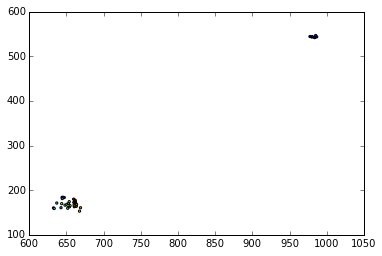

In [4]:
# %matplotlib inline
leyefinalArray = np.concatenate(leyefinalList).squeeze()
reyefinalArray = np.concatenate(reyefinalList).squeeze()
allTrackedPointsArray = np.concatenate(allTrackedPointsList,2)
plt.figure(0)
for i in range(1):
    plt.scatter(allTrackedPointsArray[i,0,:],allTrackedPointsArray[i,1,:],5,range(0,allTrackedPointsArray.shape[2]))
# plt.figure(1)
# plt.scatter(leyefinalArray[:,0],leyefinalArray[:,1],20,range(0,leyefinalArray.shape[0]))
# plt.scatter(reyefinalArray[:,0],reyefinalArray[:,1],20,range(0,reyefinalArray.shape[0]))
# plt.show()

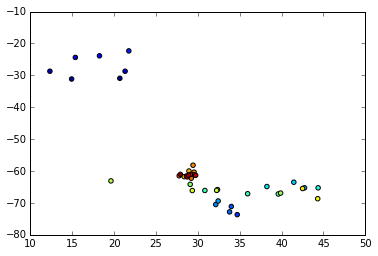

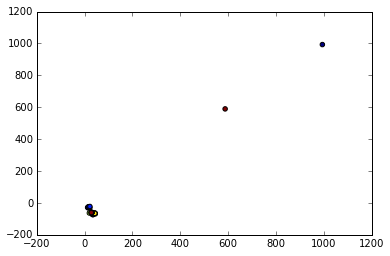

In [5]:
cIL = pt.stringIndexToIntIndex('canthusInnerLeft')
cIR = pt.stringIndexToIntIndex('canthusInnerRight')
cOL = pt.stringIndexToIntIndex('canthusOuterLeft')
cOR = pt.stringIndexToIntIndex('canthusOuterRight')
cILArray = allTrackedPointsArray[cIL,:,:]
cIRArray = allTrackedPointsArray[cIR,:,:]
cOLArray = allTrackedPointsArray[cOL,:,:]
cORArray = allTrackedPointsArray[cOR,:,:]
mid = (cILArray + cIRArray + cOLArray + cORArray)/4
leyeWRT = leyefinalArray - mid.transpose()
reyeWRT = reyefinalArray - mid.transpose()
plt.figure('wrt')
plt.scatter(leyeWRT[:,0],leyeWRT[:,1],20,range(0,leyeWRT.shape[0]))
plt.figure('mid')
plt.scatter(leyeWRT[:,0],leyeWRT[:,1],20,range(0,leyeWRT.shape[0]))
plt.scatter(mid[:,0],mid[:,1],20,range(0,mid.shape[0]))
plt.show('wrt')
plt.show('mid')


In [6]:
pcl.irisRange

array([ 27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.])